In [3]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
import nltk
from nltk import download
download('stopwords')
from nltk.corpus import stopwords


import json
import gzip
import os
import sys
import argparse
#import panda as pd
import matplotlib.pyplot as plt
import re
# Library for boxplots
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#from tensorflow.keras.layers import Attention
#from attention import AttentionLayer

#from keras_self_attention import SeqSelfAttention
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malog\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [4]:
def readData(path,filename):
    json_obj_list=[]
    with open(os.path.join(path,filename),'r') as fin:
        for row in fin:
            json_obj_list.append(json.loads(row))
    return json_obj_list

In [5]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                print("contract")
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.14s/it]


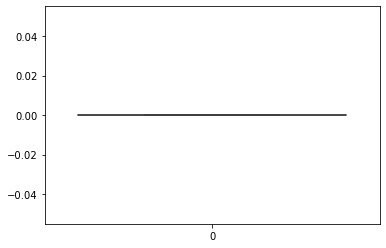

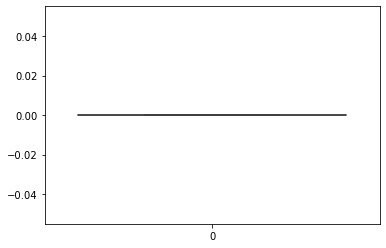

In [6]:
# A remplacer par "train"  "val"   "test"
kind_data="train"

file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file][:10]
diff_abs,diff_des=[],[]
for file_name in tqdm(file_names):
    
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)
    #print(listJSON)
    #JSONlist=filterChars(os.path.join("data",kind_data,"g"),file_name,listJSON)
    for i in range(len(listJSON)) :
        abstract = listJSON[i]['abstract']
        description = listJSON[i]['description']
        txt2_ab=clean_text(abstract, remove_stopwords = True)
        if len(abstract)!=len(txt2_ab):
            print(file_name, ", row ",i," abs-abs2 : ",len(abstract)-len(txt2_ab))
        diff_abs.append(len(abstract)-len(txt2_ab))
        txt2_de=clean_text(description, remove_stopwords = True)
        if len(description)!=len(txt2_de):
            print(file_name, ", row ",i," des-des2 : ",len(description)-len(txt2_de))
        diff_des.append(len(description)-len(txt2_de))

diff_abs,diff_des=np.array(diff_abs),np.array(diff_des)
        
sns.boxplot(data=diff_abs,fliersize=10)   
plt.show()      
sns.boxplot(data=diff_des,fliersize=10)   
plt.show()      

        

### Mesure des tailles 

In [7]:
abstract_word_count = []
description_word_count = []
file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for file_name in tqdm(file_names): 

    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)
    for i in range(len(listJSON)) :
        abstract = listJSON[i]['abstract']
        description = listJSON[i]['description']
        
        abstract_word_count.append(len(abstract.split()))
        description_word_count.append(len(description.split()))
        


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [03:01<00:00,  1.17s/it]


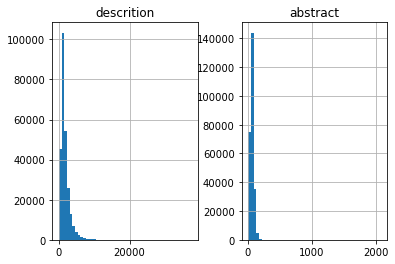

In [8]:

length_df = pd.DataFrame({'descrition': description_word_count, 'abstract': abstract_word_count})
length_df.hist(bins=50)
plt.show()

In [9]:
print(max(description_word_count))
print(max(abstract_word_count))

37456
2074


In [10]:
abstract_count = 0
description_count = 0
count=0
lim_abs =160
lim_des = 9000
file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for file_name in tqdm(file_names): 

    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)
    for i in range(len(listJSON)) :
        count+=1
        abstract = listJSON[i]['abstract']
        description = listJSON[i]['description']
        
        if(len(abstract.split())<=lim_abs):
            abstract_count += 1
        if(len(description.split())<=lim_des):
            description_count += 1


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [02:50<00:00,  1.10s/it]


In [11]:
print(" nombre de description de taille inférieure à ",lim_des , " : ",description_count/count)    
print(" nombre d 'abstract de taille inférieure à ",lim_abs , " : ",abstract_count/count)   
print(count)

 nombre de description de taille inférieure à  9000  :  0.99562438449804
 nombre d 'abstract de taille inférieure à  160  :  0.9963813312221214
258935


# Tokenization

## Sur Description

In [13]:
kind_data="train"

x_tokenizer = Tokenizer() 
#x_tokenizer.fit_on_texts(_____)

file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for i in tqdm(range(len(file_names))) : 
    file_name=file_names[i]
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)

    descriptions = [i['description'] for i in listJSON  ]#listJSON[:]['description']
    x_tokenizer.fit_on_texts(descriptions)

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [16:10<00:00,  6.26s/it]


In [14]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in tqdm(x_tokenizer.word_counts.items()):
    tot_cnt=tot_cnt+1
    
    tot_freq=tot_freq+value
    if tot_cnt<10 :
        print(key,value)
    
    
    if(value<thresh):
        
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100,"%")
print("Total Coverage of rare words:",(freq/tot_freq)*100,"%")

 15%|██████████▍                                                            | 86359/588085 [00:00<00:01, 416743.90it/s]

referring 367900
fig 5199387
service 309448
technician 13298
visiting 2887
customer 210628
location 405434
provided 808434
input 1283124


100%|██████████████████████████████████████████████████████████████████████| 588085/588085 [00:01<00:00, 383767.32it/s]

% of rare words in vocabulary: 59.7163675319044 %
Total Coverage of rare words: 0.11371321630587963 %


In [15]:
#prepare a LIMITED tokenizer for reviews on training data
tokenizer_description = Tokenizer(num_words=tot_cnt-cnt) 


file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for i in tqdm(range(len(file_names))) : 
    file_name=file_names[i]
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)

    descriptions = [i['description'] for i in listJSON  ]
    tokenizer_description.fit_on_texts(descriptions)

100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [1:19:10<00:00, 30.65s/it]


## Abstract

In [16]:
x_tokenizer = Tokenizer() 
#x_tokenizer.fit_on_texts(_____)

file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for i in tqdm(range(len(file_names))) : 
    file_name=file_names[i]
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)

    abstracts = [i['abstract'] for i in listJSON  ]#listJSON[:]['description']
    x_tokenizer.fit_on_texts(abstracts)

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [02:35<00:00,  1.00s/it]


In [17]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in tqdm(x_tokenizer.word_counts.items()):
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    
    if(value<thresh):
        
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100,"%")
print("Total Coverage of rare words:",(freq/tot_freq)*100,"%")

100%|████████████████████████████████████████████████████████████████████████| 68948/68948 [00:00<00:00, 380128.04it/s]

% of rare words in vocabulary: 47.82009630446134 %
Total Coverage of rare words: 0.2959113934193723 %


In [18]:
#prepare a LIMITED tokenizer for reviews on training label
tokenizer_abstract = Tokenizer(num_words=tot_cnt-cnt) 


file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
for i in tqdm(range(len(file_names))) : 
    file_name=file_names[i]
    listJSON = readData(os.path.join("data",kind_data,"g"),file_name)

    abstracts = [i['abstract'] for i in listJSON  ]
    tokenizer_abstract.fit_on_texts(abstracts)

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [02:40<00:00,  1.03s/it]


## Save des token

In [19]:
def create_tokenize_file(path,filename,JSONlist,tokenizer_x,tokenizer_y):
    
    if os.path.exists(path+'new_tok_'+filename+'.txt')==True:
        os.remove(path+'new_tok_'+filename)
        
    descriptions = [i['description'] for i in JSONlist  ]
    x_tr_seq   =  tokenizer_x.texts_to_sequences(descriptions)
    
    
    
    abstracts = [i['abstract'] for i in JSONlist  ]
    y_tr_seq   =  tokenizer_y.texts_to_sequences(abstracts) 
    
    #print(len(x_tr_seq))
    #print(x_tr_seq)
    
    new_f= open(path+'new_tok'+filename,'a')
  
    for i in range(len(JSONlist)) :
        #JSONlist[i]['abstract']=x_tr_seq[i]
        #JSONlist[i]['description']=y_tr_seq[i]
    
        updatedJSON={"publication_number":JSONlist[i]['publication_number'],"abstract":x_tr_seq[i],"description":y_tr_seq[i]}
        new_f.write(json.dumps(updatedJSON))
        
        
    #print("Wrote file "+new_f.name)
    new_f.close()
    
    #f2= open(path+'new_tok'+filename,'r')
    #text = f2.read().replace('}{"publication_number"','}\n{"publication_number"').encode("utf8")
    
    #f2.write(str(text))
    #f2.close()
    
def addLineReturn(path,filename):
    f=open(os.path.join(path,file_name2),'r')
    text = f.read().replace('}{"publication_number"','}\n{"publication_number"').encode("utf8")
    f.close()
    f2=open(os.path.join(os.path.join("data",kind_data,"g"),file_name2),'wb')
    f2.write(text)
    f2.close()
    print("Updated file "+f2.name)
    


In [20]:
#### Enregistrement des données tokénisés
os.makedirs("data_token", exist_ok=True)
for kind_data in ["train","val","test"]:
    name_folder0 = "data_token/"+kind_data
    name_folder = "data_token/"+kind_data+"/g"
    os.makedirs(name_folder0, exist_ok=True)
    os.makedirs(name_folder, exist_ok=True)
    
    file_names = [file for file in os.listdir(os.path.join("data",kind_data,"g")) if ".txt" in file]
    for i in tqdm(range(len(file_names))) :
        file_name=file_names[i]
        listJSON = readData(os.path.join("data",kind_data,"g"),file_name) 

        
        
        #Padding ?????????????????????????????????????
        #x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
        #x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
    
        #on save ici le fichier à l'adresse
        create_tokenize_file(name_folder+"/",file_name,listJSON,tokenizer_description,tokenizer_abstract)

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:55<00:00,  2.79it/s]


In [21]:
##SAVE LES TOKENIZER
##MEME TOKENIZER POUR X ET Y ?????

In [22]:
###### Du test
file_names = [file for file in os.listdir(os.path.join("data","train","g")) if ".txt" in file]
for i in tqdm(range(len(file_names[0]))) : 
    file_name=file_names[i]

    listJSON = readData(os.path.join("data","train","g"),file_name)
    descriptions = [i['description'] for i in listJSON  ]
    abstracts = [i['abstract'] for i in listJSON  ]


x_tr_seq   =  tokenizer_description.texts_to_sequences(descriptions)

print(len(descriptions[0]))
print(len(x_tr_seq[0]))
print(x_tr_seq[0])

print(len(x_tr_seq))
print(len(descriptions))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.42it/s]


3867
481
[44, 1160, 40074, 1528, 1821, 7, 867, 303, 1078, 9, 151, 170, 900, 52, 21, 26, 441, 565, 31, 31, 25, 35, 167, 35, 82, 31, 2, 84, 1621, 2361, 3589, 88805, 1887, 1438, 1158, 21, 185, 63696, 2855, 174401, 278, 544, 104, 380, 84, 12517, 1530, 12517, 1530, 167, 6, 35, 82, 121, 380, 84, 170, 900, 170, 900, 2155, 82, 31, 25, 35, 82, 1530, 595, 1096, 5254, 900, 1743, 1814, 28, 1466, 132, 489, 6, 51, 31, 25, 35, 167, 88, 1814, 28, 1466, 132, 2584, 278, 1044, 47, 31, 62, 489, 222, 31, 25, 35, 519, 1044, 278, 25, 900, 519, 136, 278, 17, 808, 1466, 132, 123, 2889, 222, 25, 35, 1466, 132, 583, 104, 278, 1044, 47, 31, 2889, 222, 1031, 867, 1160, 2889, 222, 51, 1466, 132, 25, 35, 293, 121, 28, 1466, 132, 28, 121, 1466, 132, 163, 586, 28, 28, 35, 121, 1466, 132, 1466, 132, 1519, 2889, 222, 4, 2490, 5528, 15210, 847, 1577, 2889, 222, 1189, 222, 2, 762, 1088, 1375, 422, 6094, 222, 7278, 1015, 970, 2, 1541, 147, 4941, 31, 544, 104, 278, 166, 501, 7, 1151, 19970, 508, 3727, 128, 41, 31, 334, 314,

In [25]:
#print(tokenizer_description.get_config())
print(tokenizer_abstract.get_config())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
### Enregistrement du tokenizer
path = "data_token/"

Json_tok_ab = tokenizer_abstract.to_json()
new_f_ab = open(path+'tokenizer_abstract.txt','a')
new_f_ab.write(json.dumps(Json_tok_ab))
new_f_ab.close()

Json_tok_de = tokenizer_description.to_json()
new_f_de = open(path+'tokenizer_description.txt','a')
new_f_de.write(json.dumps(Json_tok_ab))
new_f_de.close()





In [ ]:
 for i in range(len(JSONlist)) :
        abstract = JSONlist[i]['abstract']
        description = JSONlist[i]['description']
            
        abstract1 = abstract.lower()
        description1 = description.lower()
            
        abstract2 = re.sub('[^a-zA-Z ]',' ',abstract1)
        description2 = re.sub('[^a-zA-Z ]',' ',description1)
            
        abstract3 = re.sub(r'(?:^| )\w(?:$| )', ' ', abstract2).strip()
        description3 = re.sub(r'(?:^| )\w(?:$| )', ' ', description2).strip()
            
        abstract4 = ' '.join([word for word in abstract3.split() if word not in cachedstopwords])
        description4 = ' '.join([word for word in description3.split() if word not in cachedstopwords])
            
        abstract5=re.sub(' +',' ',abstract4)
        description5=re.sub(' +',' ',description4)
            
        JSONlist[i]['abstract']=abstract5
        JSONlist[i]['description']=description5
        updatedJSON={"publication_number":JSONlist[i]['publication_number'],"abstract":abstract5,"description":description5}
        new_f.write(json.dumps(updatedJSON))
    print("Wrote file "+new_f.name)
    new_f.close()
    return JSONlist

In [48]:


#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(x_voc)

NameError: name 'x_tr' is not defined

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sj_train_features_scaled = sj_train_features.copy()


sj_train_features_scaled[sj_train_features_scaled.columns]= scaler.fit_transform(sj_train_features[sj_train_features.columns])

In [ ]:
sj_train_features_scaled['total_cases'] = sj_train_features['total_cases']

In [ ]:
train_data_normalized_torch = []
for column in sj_train_features_scaled.columns:
    train_data_normalized_torch.append(torch.FloatTensor(sj_train_features_scaled[column]))

In [ ]:
#On test en selectionnant un certain nombre de features

features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c','total_cases']

train_data_selected_torch = [torch.FloatTensor(sj_train_features_scaled[feature]) for feature in features]

In [ ]:
def create_inout_sequences(input_data, tw): #remplacer lim-1 par 20 si ça bug
    inout_seq = []
    L = len(input_data[0])
    lim = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[0][i:i+tw].view(tw,1,-1)
        for j in range(1,lim-1):
            train_seq = torch.cat((train_seq,input_data[j][i:i+tw].view(tw,1,-1)),-1)

        train_label = input_data[lim-1][i+tw]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
inout_seq = create_inout_sequences(train_data_normalized_torch, 52)

In [ ]:
inout_seq_selected = create_inout_sequences(train_data_selected_torch, 52)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=20, hidden_layer_size=150, output_size=1): #hidden_layer_size = 100
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions[0]

In [ ]:
model = LSTM()
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import math
training_ratio = 0.8
training_data = inout_seq[0:math.floor(training_ratio*len(inout_seq))]
valid_data = inout_seq[math.floor(training_ratio*len(inout_seq)):-1]

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(inout_seq):
    train_chouchou = [inout_seq[i] for i in train_index]
    train_chouchou = [inout_seq[i] for i in test_index]

In [ ]:
epochs = 50
training_loss=[]
valid_loss=[]
for train_index, test_index in kf.split(inout_seq):
    training_data = [inout_seq[i] for i in train_index]
    valid_data = [inout_seq[i] for i in test_index]
    for i in range(epochs):
        if i == 100:
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        model.train()

        for seq, labels in training_data:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)
            single_loss_r = loss_function(y_pred[0][0], labels)
            single_loss_r.backward()
            training_loss.append(single_loss_r.item())
            optimizer.step()
        model.eval()
        for seq, labels in valid_data:
            y_pred = model(seq)
            running_loss = loss_function(y_pred[0][0], labels)
            valid_loss.append(running_loss.item())

        print("Epoch: ",i, "__ Training Loss: ", training_loss[-1],"__ Valid Loss:", valid_loss[-1])
